# G-CAUSALITY: Evaluating Causal Relationships Between Diagnoses

This Python notebook is designed to develop the causality layer of the forecasting algorithm. Using the database of diagnostic variables and the feature selection subset derived from the CCM (Convergent Cross Mapping) framework, this module verifies whether the selected predictors maintain a Granger-causal relationship with the target variable.

The rationale is that a truly predictive variable should not only correlate with the target but also precede and cause changes in it under the assumptions of Granger causality. Therefore, if any variable in the selected predictor set does not Granger-cause the target diagnosis, it will be removed, refining the feature selection process and improving the robustness of the model.


### INDEX

- 0. Worked Example: Application of the Granger causality test using the predictor set with the lowest prediction error under the CCM framework.

- 1. Extended Predictors from CCDLL Framework: Evaluation of a broader set of predictors that achieved competitive MAPE results, testing their causal relationships.

- 2. Random Predictors: Use of randomly selected variables to serve as a control group, verifying the specificity of Granger causality in informative predictors.

- 3. Minimum MAPE Without Smoothing: Evaluation of the best CCM-based feature set on raw, non-smoothed data to assess the effect of pre-processing on causal detection.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
# no warnings
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import random
import igraph as ig

In [10]:
def smoother(df,window_size):
    smoothed = {}
    for column in df.columns:
        if column != 'visi_data_visita':
            column_list = []
            for i in range(len(df)):
                if i == 0:
                    column_list.append(df[column].iloc[0])
                elif i < window_size:
                    column_list.append(df[column].iloc[:i+1].mean())
                else:
                    column_list.append(df[column].iloc[i-window_size:i+1].mean())
            smoothed[column] = column_list

    smoothed = pd.DataFrame.from_dict(smoothed)
    smoothed.set_index(df.index, inplace=True)
    return smoothed

# RAW DATA --------------------------------------------------------------
df = pd.read_csv('synthetic_timeseries.csv', index_col=0)
df.index = pd.date_range(start="2010-01-01", periods=len(df), freq="D")
df = df.clip(lower=0)

window_size = 14
smoothed = smoother(df, window_size)

smoothed_scaled = (smoothed-smoothed.min())/(smoothed.max()-smoothed.min()) # normalize df

smoothed = smoothed_scaled

In [128]:
target = ["timeseries_350"]
predictors = ['timeseries_405','timeseries_363','timeseries_975','timeseries_120','timeseries_2','timeseries_541','timeseries_775',
              'timeseries_181','timeseries_692','timeseries_443','timeseries_763','timeseries_31','timeseries_324'] 

## 0. check plot lines

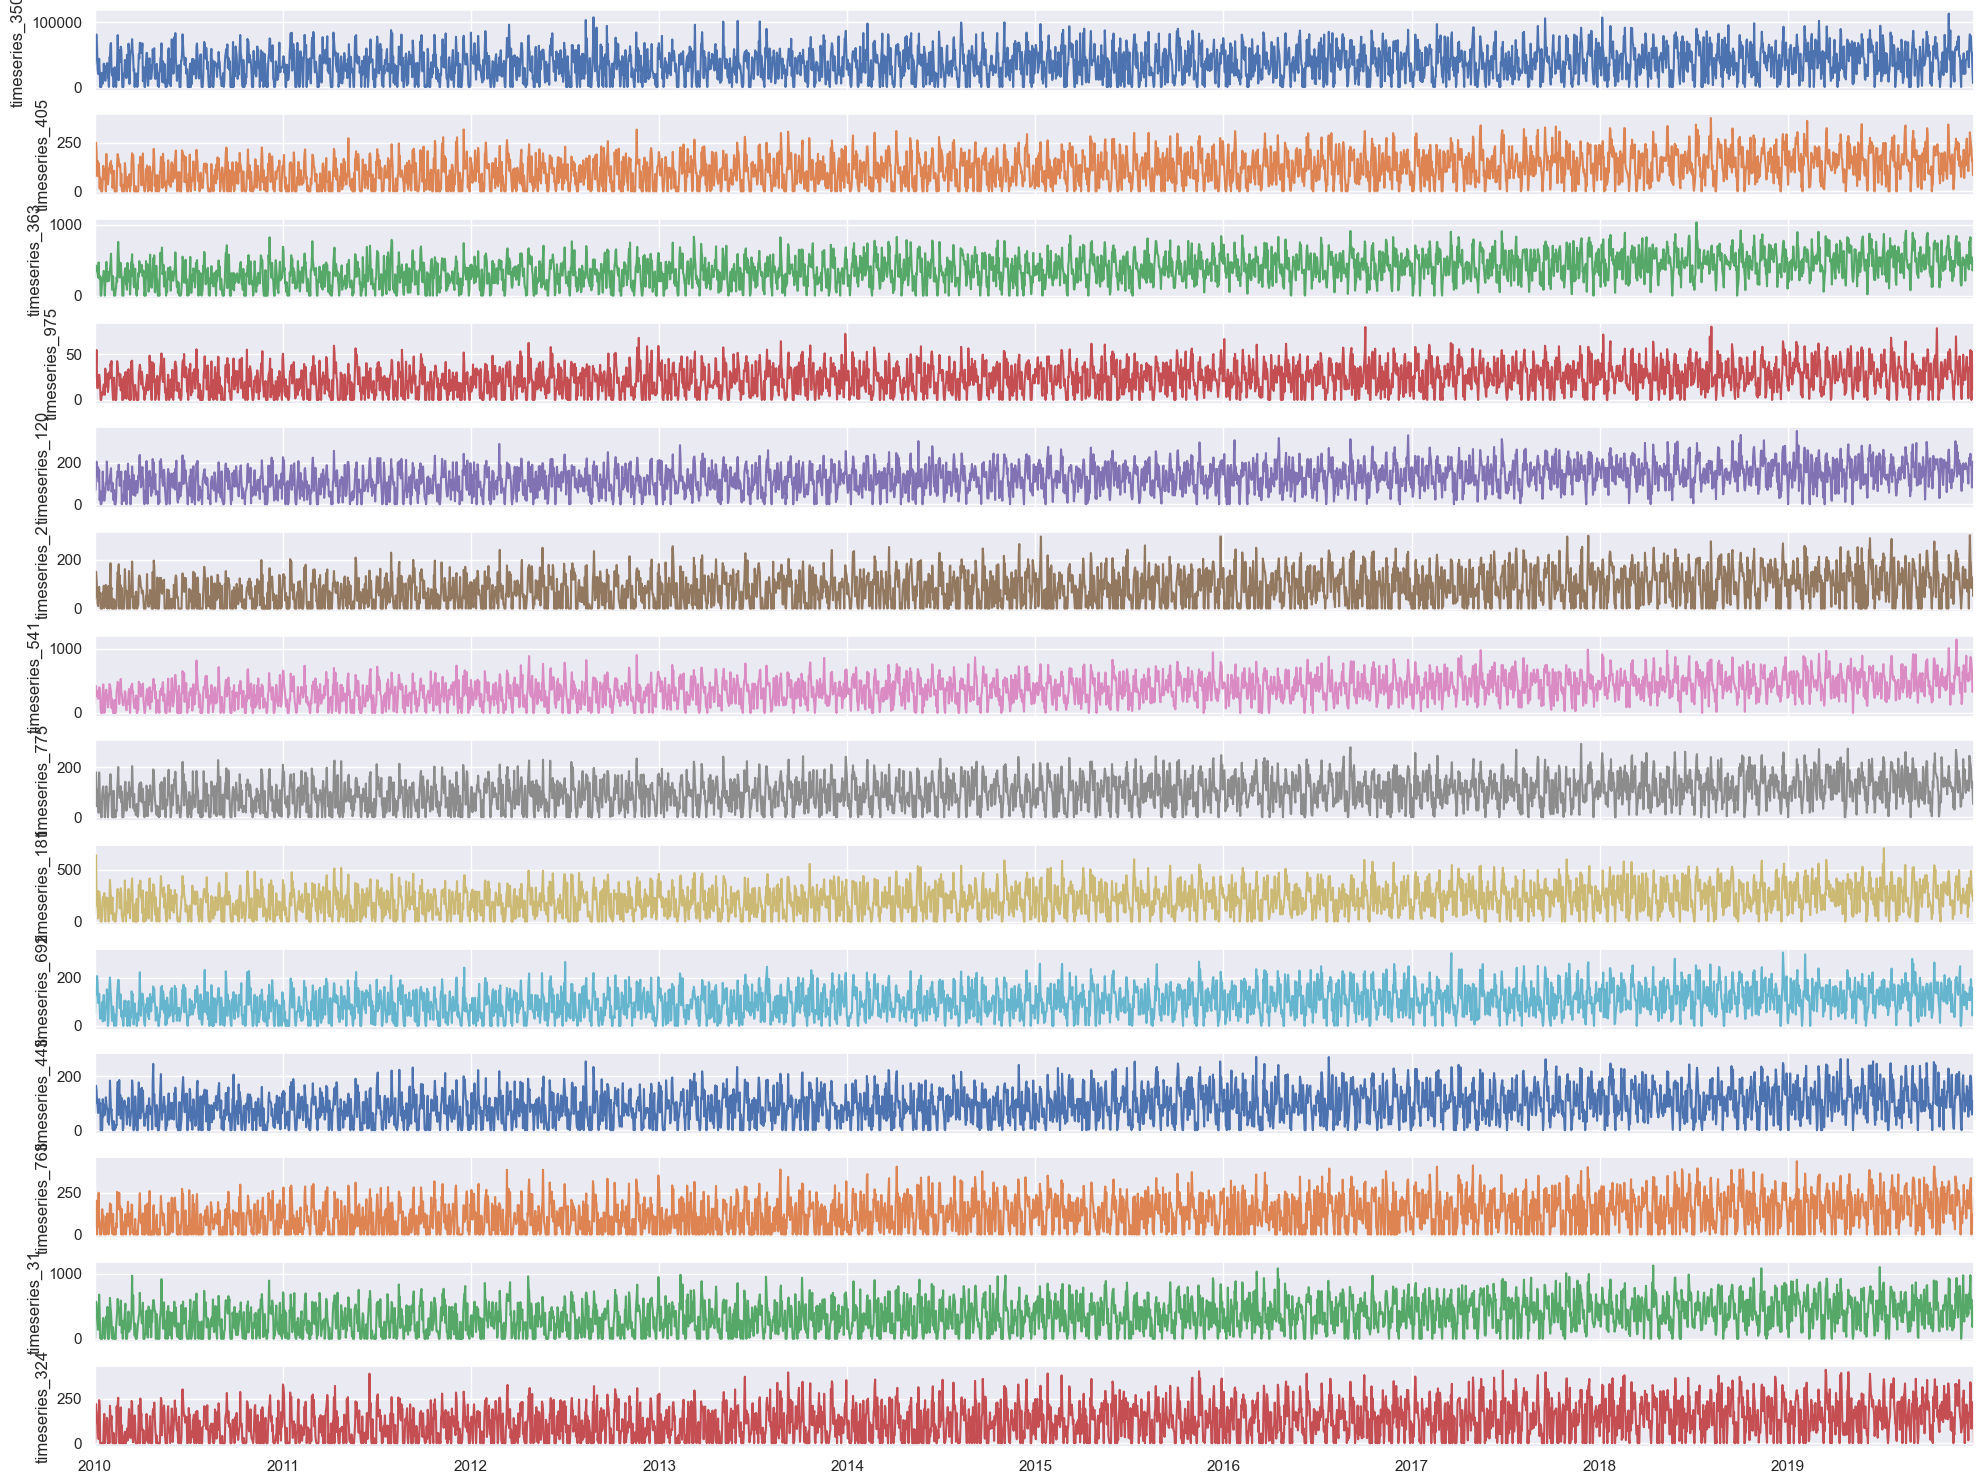

In [130]:
fig,ax = plt.subplots(len(target+predictors), figsize=(20,15), sharex=True)
plot_cols = target+predictors
df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

### 0.1. Stationarity (check)

In [131]:
def lag_plots(data_df):
    
    ncol = data_df.shape[1]
    f, axes = plt.subplots(1, ncol, figsize=(15, 5))
    axes = [axes[i] for i in range(ncol)]

    for i in range(0,ncol):
        lag_plot(data_df[data_df.columns[i]], ax=axes[i])
        axes[i].set_title(data_df.columns[i]);

        axes[i].set_ylabel('$y_{t+1}$');
        axes[i].set_xlabel('$y_t$');
    
    plt.tight_layout()
    plt.show()

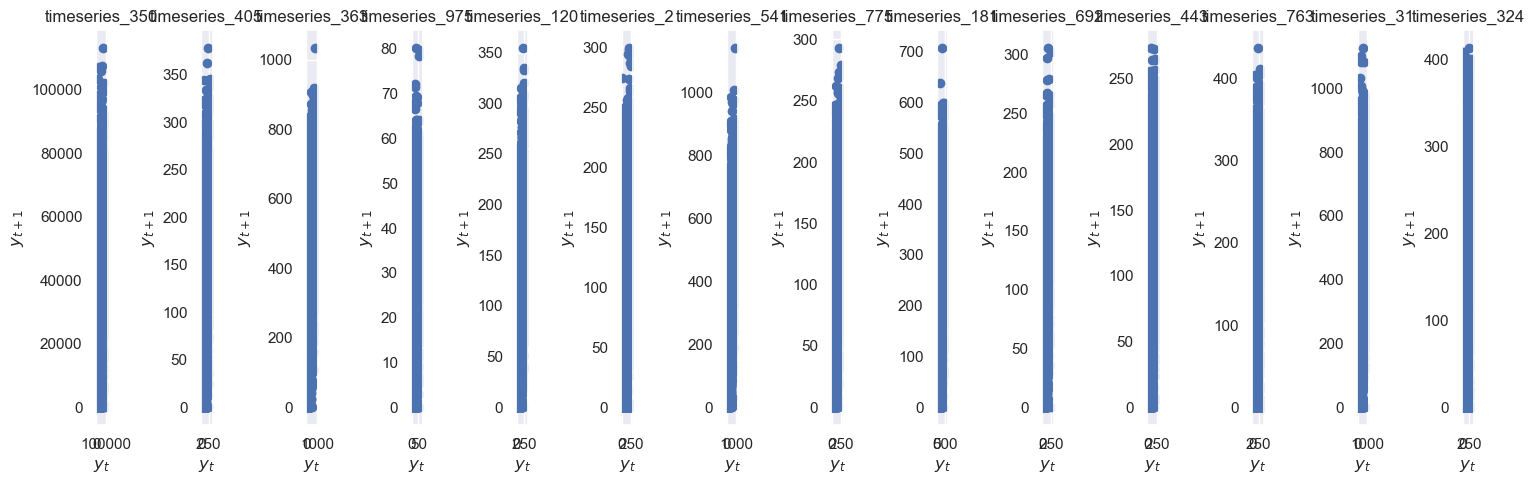

In [132]:
variables = [target+predictors]
variables = [item for sublist in variables for item in sublist]
lag_plots(df[variables[0:len(plot_cols)]])

Result: lag plots are inconclusive.

In [133]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    valid_cols = []

    for c in data_df.columns: 
        series = data_df[c].dropna()

        # Skip if all values are NaN or series is constant
        if series.nunique() <= 1 or len(series) < 10:
            print(f"⚠️ Skipping {c}: too few values or constant.")
            continue

        try:
            kpss_res = kpss(series, regression='ct', nlags='auto')
            test_stat.append(kpss_res[0])
            p_val.append(kpss_res[1])
            cv_1pct.append(kpss_res[3]['1%'])
            cv_2p5pct.append(kpss_res[3]['2.5%'])
            cv_5pct.append(kpss_res[3]['5%'])
            cv_10pct.append(kpss_res[3]['10%'])
            valid_cols.append(c)
        except ValueError as e:
            print(f"⚠️ Skipping {c}: {e}")
            continue

    kpss_res_df = pd.DataFrame({
        'Test statistic': test_stat, 
        'p-value': p_val, 
        'Critical value - 1%': cv_1pct,
        'Critical value - 2.5%': cv_2p5pct,
        'Critical value - 5%': cv_5pct,
        'Critical value - 10%': cv_10pct
    }, index=valid_cols).T

    return kpss_res_df.round(4)

def stationate(data_df,l):
    for i in l:
        data_df[i] = data_df[i] - data_df[i].shift(1)
        data_df = data_df.dropna()
    return data_df

In [134]:
display(kpss_test(df[plot_cols]))

indexes = kpss_test(df[plot_cols]).T[kpss_test(df[plot_cols]).T['p-value'] < 0.05].index.tolist()
print(indexes)

,timeseries_350,timeseries_405,timeseries_363,timeseries_975,timeseries_120,timeseries_2,timeseries_541,timeseries_775,timeseries_181,timeseries_692,timeseries_443,timeseries_763,timeseries_31,timeseries_324
Test statistic,0.0592,0.0845,0.0795,0.0299,0.1412,0.067,0.0327,0.0575,0.0506,0.0738,0.0706,0.0479,0.0796,0.0747
p-value,0.1000,0.1000,0.1000,0.1000,0.0589,0.100,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160,0.216,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760,0.176,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460,0.146,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190,0.119,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190


[]


Since all pvals are <0.05 we can conclude all vcariables are not stationary. Since both the lag plot and KPSS test indicate that vars are not stationary, we apply differencing first before building our VAR model.

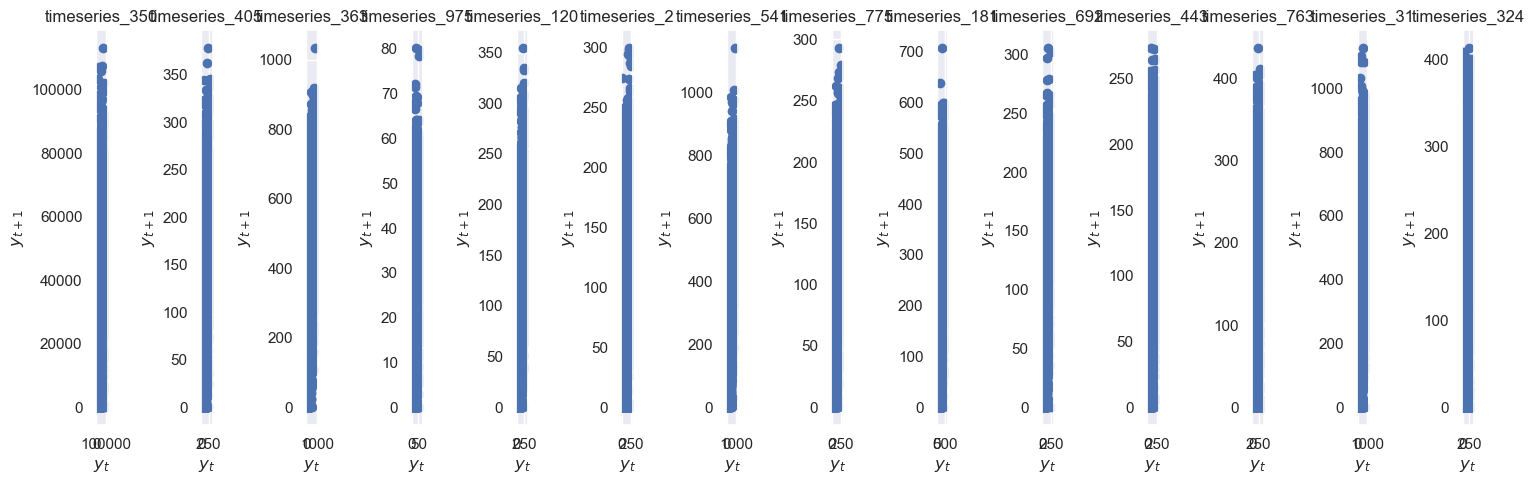

,timeseries_350,timeseries_405,timeseries_363,timeseries_975,timeseries_120,timeseries_2,timeseries_541,timeseries_775,timeseries_181,timeseries_692,timeseries_443,timeseries_763,timeseries_31,timeseries_324
Test statistic,0.0592,0.0845,0.0795,0.0299,0.1412,0.067,0.0327,0.0575,0.0506,0.0738,0.0706,0.0479,0.0796,0.0747
p-value,0.1000,0.1000,0.1000,0.1000,0.0589,0.100,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160,0.216,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760,0.176,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460,0.146,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190,0.119,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190


[]


In [135]:
# first order stationarity
stationate_df = stationate(df[plot_cols],indexes)
lag_plots(stationate_df[variables[0:len(plot_cols)]])


display(kpss_test(stationate_df))
indexes = kpss_test(stationate_df).T[kpss_test(stationate_df).T['p-value'] < 0.05].index.tolist()
print(indexes)

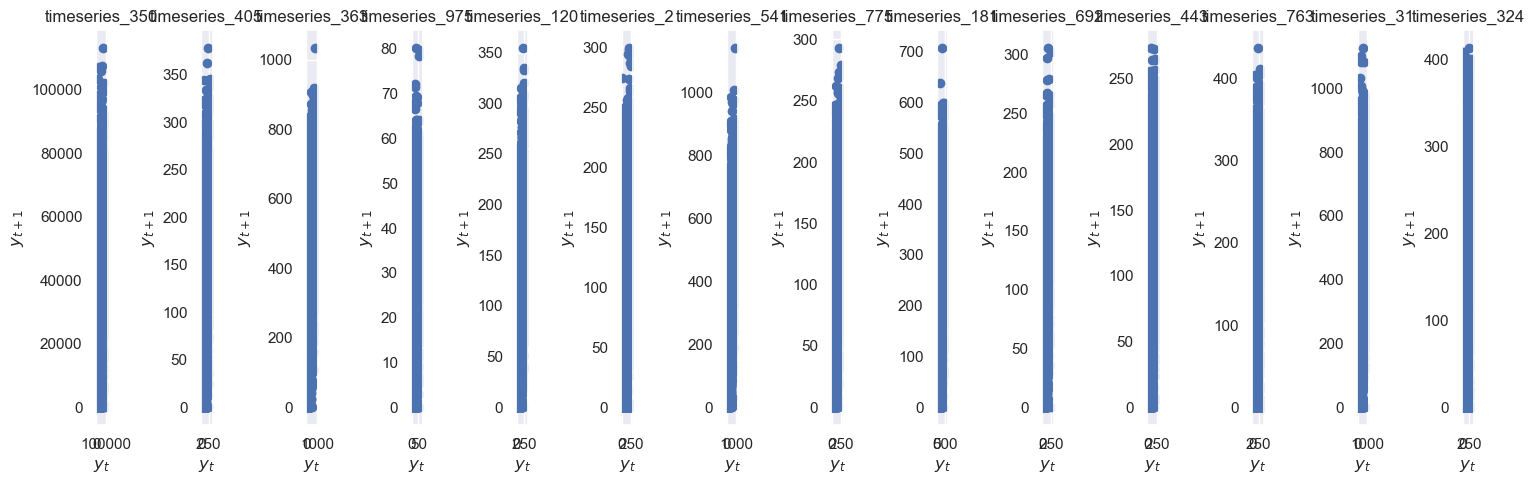

,timeseries_350,timeseries_405,timeseries_363,timeseries_975,timeseries_120,timeseries_2,timeseries_541,timeseries_775,timeseries_181,timeseries_692,timeseries_443,timeseries_763,timeseries_31,timeseries_324
Test statistic,0.0592,0.0845,0.0795,0.0299,0.1412,0.067,0.0327,0.0575,0.0506,0.0738,0.0706,0.0479,0.0796,0.0747
p-value,0.1000,0.1000,0.1000,0.1000,0.0589,0.100,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160,0.216,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760,0.176,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460,0.146,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190,0.119,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190


In [138]:
# second order stationarity   
stationate_df = stationate(stationate_df,indexes)
lag_plots(stationate_df[variables[0:len(plot_cols)]])

display(kpss_test(stationate_df))

### 0.2. G-Causality test

In [144]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    plt.show()
    print(lags_metrics_df.idxmin(axis=0))

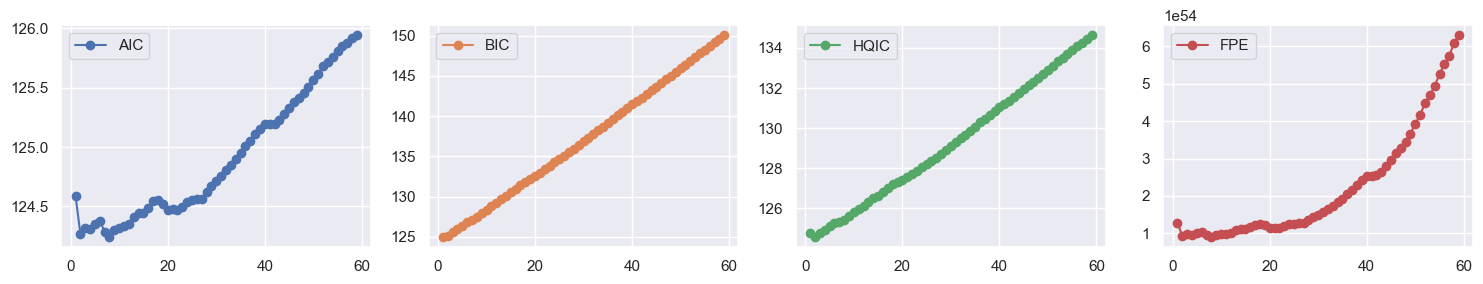

AIC     8
BIC     1
HQIC    2
FPE     8
dtype: int32


In [146]:
train_df, test_df = splitter(stationate_df)
select_p(train_df)

Result: We see that BIC has the lowest value at p=7 while HQIC at p=30. Although both AIC and FPE have the lowest value at p=30, their plots also show an elbow. We can thus select the number of lags to be 30 (also for computational efficiency).

In [147]:
model = VAR(train_df)
var_model = model.fit(p)

In [148]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [149]:
display(granger_causation_matrix(train_df, train_df.columns, p=1))
display(granger_causation_matrix(train_df, train_df.columns, p=7))
display(granger_causation_matrix(train_df, train_df.columns, p=30))

,timeseries_350_x,timeseries_405_x,timeseries_363_x,timeseries_975_x,timeseries_120_x,timeseries_2_x,timeseries_541_x,timeseries_775_x,timeseries_181_x,timeseries_692_x,timeseries_443_x,timeseries_763_x,timeseries_31_x,timeseries_324_x
timeseries_350_y,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_405_y,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_363_y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_975_y,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_120_y,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_2_y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_541_y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_775_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_181_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
timeseries_692_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,timeseries_350_x,timeseries_405_x,timeseries_363_x,timeseries_975_x,timeseries_120_x,timeseries_2_x,timeseries_541_x,timeseries_775_x,timeseries_181_x,timeseries_692_x,timeseries_443_x,timeseries_763_x,timeseries_31_x,timeseries_324_x
timeseries_350_y,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_405_y,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_363_y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_975_y,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_120_y,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_2_y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_541_y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_775_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_181_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
timeseries_692_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,timeseries_350_x,timeseries_405_x,timeseries_363_x,timeseries_975_x,timeseries_120_x,timeseries_2_x,timeseries_541_x,timeseries_775_x,timeseries_181_x,timeseries_692_x,timeseries_443_x,timeseries_763_x,timeseries_31_x,timeseries_324_x
timeseries_350_y,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_405_y,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_363_y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_975_y,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_120_y,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_2_y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_541_y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_775_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
timeseries_181_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
timeseries_692_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Recall: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

Results: For this particular example, we can say that when taking into account T14, all variables present in the subset cause T14 at lag 7. This means that changes in variables improve T14 prediction performance at lag 30.